# Yoonhyuck WOO / Purdue University_Computer and Information Technology
# Assignment 1: Supervised Learning Tasks
# Professor: Dr. Pradhan

## Date: 1.19 - 5:00pm 2/2/2024 (EST)

In the lecture, we briefly discussed supervised and unsupervised learning in the context of machine learning. In this assignment, we will go through binary classification tasks on one of the most popular datasets in the fairness in machine learning literature.

We will:
1. Import the data, implement a few pre-processing steps, and inspect the data
2. Run a short exploratory analysis of the target variable
3. Train a binary classifier and evaluate the classifier using the predicted labels

# Packages and Modules

You may need to install the following packages:




In [1]:
%pip install pandas numpy statsmodels matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


Import the packages and modules:


In [376]:
import math
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import sklearn
import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from IPython.display import Markdown, display, Image
import matplotlib.pyplot as plt
import warnings

from IPython.core.display import HTML 
import operator
from collections import defaultdict

import json
from collections import OrderedDict

import numpy as np
import pandas as pd

np.random.seed(1)

### Step 1: Load Data

For this assignment, we will work with the German Credit dataset which has been provided with this notebook (the dataset can also be downloaded from the UCI ML repository). The dataset has demographic and financial information for about 1,000 individuals, and 

## **the task for this dataset is to predict whether an individual is a good credit risk or a bad credit risk**. 

More information about the dataset can be found here:
https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data.

Load the dataset and check the first few rows:

In [240]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment',\
            'install_rate', 'personal_status', 'debtors', 'residence', 'property', 'age', 'install_plans',\
            'housing', 'num_credits', 'job', 'num_liable', 'telephone', 'foreign_worker', 'credit']

data_df = pd.read_table('D:\DOWNLOAD\statlog+german+credit+data/german.data', names=cols, sep=" ", index_col=False)
y = data_df['credit']

print("Shape: ", data_df.shape)
data_df.head(5)

Shape:  (1000, 21)


,status,duration,credit_hist,purpose,credit_amt,savings,employment,install_rate,personal_status,debtors,...,property,age,install_plans,housing,num_credits,job,num_liable,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Step 2: Data preprocessing

For our analysis, we will preprocess the dataset to get additional columns and bucketize some columns with numeric data. In particular, we will do the following:
1. Create a new column "sex" that is derived from the column "personal_status". From the "personal_status" column, two values of sex can be derived: male and female (refer the data definition in the UCI ML repository to enumerate the column values of this column). Append the new column to the dataframe created above.
2. Bucketize (or, discretize) the "age" column according to a chosen threshold (say, 45). For individuals with age greater than or equal to the threshold, replace the value with "old", and those with age less than the threshold will have the value "young".

In [241]:
# write code to create the "sex" column and append to the dataframe
'''
A91 : male   : divorced/separated
A93 : male   : single
A94 : male   : married/widowed

A92 : female : divorced/separated/married
A95 : female : single
'''

sex = data_df['personal_status']

sex_list = data_df['personal_status'].tolist() 

new_sex_list = []
for i in range(len(sex_list)):
    if sex_list[i] in ("A91", "A93", "A94"): 
        i = 'male'
        new_sex_list.append(i)
    else:
        i = 'female'
        new_sex_list.append(i)

        
data_df.insert(9, "sex", new_sex_list)

# print the first few rows
data_df.head(5)

,status,duration,credit_hist,purpose,credit_amt,savings,employment,install_rate,personal_status,sex,...,property,age,install_plans,housing,num_credits,job,num_liable,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,male,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,female,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,male,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,male,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,male,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [242]:
# write code to replace the "age" column with discrete values
age_threshold = 45

data_df["age"] = np.where(data_df["age"] >= age_threshold, "old", "young")

# print the first few rows
data_df.head(5)

,status,duration,credit_hist,purpose,credit_amt,savings,employment,install_rate,personal_status,sex,...,property,age,install_plans,housing,num_credits,job,num_liable,telephone,foreign_worker,credit
0,A11,6,A34,A43,1169,A65,A75,4,A93,male,...,A121,old,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,female,...,A121,young,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,male,...,A121,old,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,male,...,A122,old,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,male,...,A124,old,A143,A153,2,A173,2,A191,A201,2


### Step 3: Exploratory data analysis

Now that we have imported the data and prepared it for analysis, we will inspect it for further analysis. Let's start by observing the distribution of the target variable and the columns we created just now.

In [243]:
sex_list = data_df['sex'].tolist() 
age_list = data_df['age'].tolist() 
credit_list = data_df['credit_amt'].tolist() 

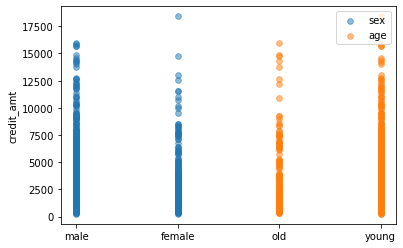

In [244]:
# write code to plot the distribution of age, sex, and credit
# in this code cell

plt.scatter(sex_list, credit_list, alpha=0.5, label='sex', s = 33)
plt.scatter(age_list, credit_list, alpha=0.5, label='age', s = 33)
plt.legend(loc='upper right')
plt.ylabel('credit_amt')
plt.show()

array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'credit_amt'}>,
        <AxesSubplot:title={'center':'install_rate'}>],
       [<AxesSubplot:title={'center':'residence'}>,
        <AxesSubplot:title={'center':'num_credits'}>,
        <AxesSubplot:title={'center':'num_liable'}>],
       [<AxesSubplot:title={'center':'credit'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

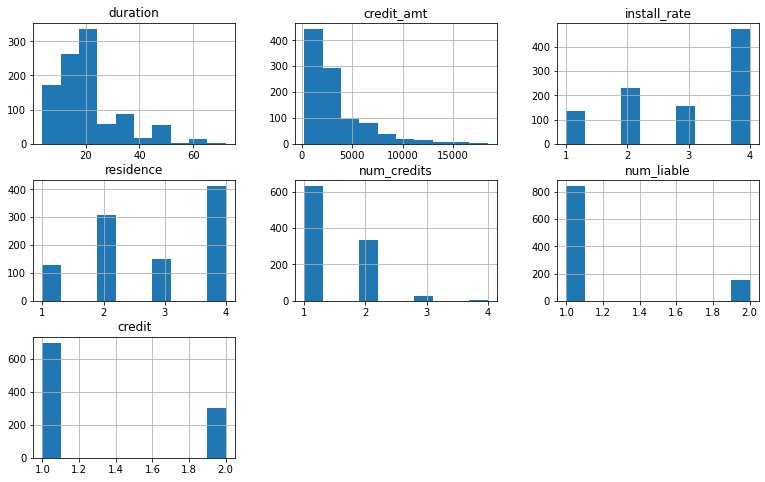

In [245]:
# You may also plot the distribution of all the columns to better understand the data
data_df.hist(figsize=(13,8))

#### **TODO: Write down your observations from the plots above**

I processed two feateures based on 'credit_amt' and 'credit'


### 3.2
Let's consider the data distribution in terms of age and sex together: generate a crosstab summarizing the number of observations by age and sex:

In [247]:
# write code to generate a crosstab summarizing the number of observations by
# age and sex (i.e. a pivot table) in this code cell
pd.crosstab(data_df['sex'], data_df['age'], margins = True)

age,old,young,All
sex,,,
female,49,261,310
male,152,538,690
All,201,799,1000


#### **3.2_TODO: Write down your observations from the results you obtained**

In this crosstab, I can only expect and say the overall ratio. In other words, if we concentrate on sex, we can see that the number of male participants in this data set is more than that of females. Regarding age, there are more young participants than old ones (the threshold is 45). Therefore, the order of crosstab sections based on size is as follows.

young male -> young female -> old male -> old female.

### 3.3 Let's turn our focus to the primary variable of interest: credit risk. In this exploratory analysis, we are interested in the variable named "credit".
Plot the distribution of credit risk for males and for females.

In [248]:
# 1 = Good, 2 = Bad
print("male_Good_Credit:", len(data_df[(data_df['sex']=='male') & (data_df['credit']==1)]))
print("female_Good_Credit:", len(data_df[(data_df['sex']=='female') & (data_df['credit']==1)]))

male_Good_Credit: 499
female_Good_Credit: 201


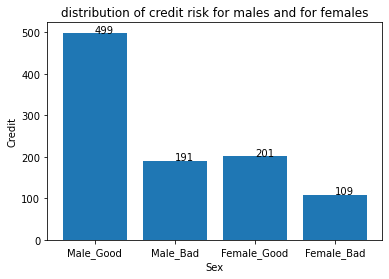

In [249]:
# making the bar chart on the data
columns = ["Male_Good", "Male_Bad","Female_Good", "Female_Bad"]
value = [499,690-499,201,310-201]
plt.bar(columns, value)

# calling the function to add value labels
def addlabels(columns, value):
    for i in range(len(columns)):
        plt.text(i,value[i],value[i])
        
addlabels(columns, value)

plt.title("distribution of credit risk for males and for females")

plt.xlabel("Sex")
plt.ylabel("Credit")

plt.show()

array([<AxesSubplot:title={'center':'female'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'male'}, ylabel='Frequency'>],
      dtype=object)

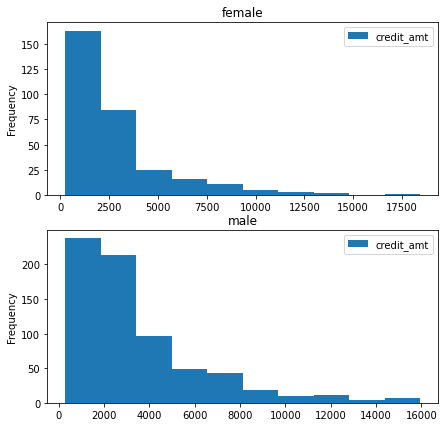

In [250]:
# plot credit risk by sex
data_df.plot.hist(column=["credit_amt"], by="sex", figsize=(7, 7))

#### **TODO: To what extent do these distributions differ? Summarize the difference between the distribution of credit risks for male and female applicants in this text cell (three sentences maximum):**



### 3.4 What about age? Repeat the above plots for young and old applicants:

array([<AxesSubplot:title={'center':'old'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'young'}, ylabel='Frequency'>],
      dtype=object)

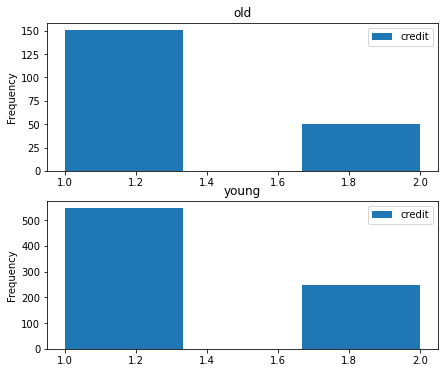

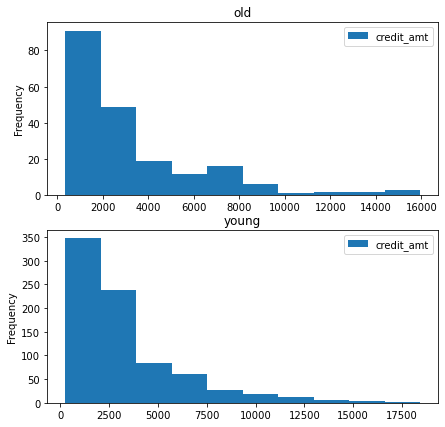

In [251]:
# write code to plot credit risk for young and old applicants in this code cell
data_df.plot.hist(column=["credit"], by="age", bins = 3, figsize=(7, 6))

data_df.plot.hist(column=["credit_amt"], by="age", figsize=(7, 7))

#### **TODO: Summarize the difference between the distribution of credit risks for young and old applicants in this text cell (three sentences maximum):**

### Step 4: Train a classifier to predict credit using the original data

We will be training a logistic regression model to predict good/bad credit, then fine-tuning the model over a set of hyperparameters. For this purpose, we will use sklearn's logistic regression model. However, the model expects the data to be in numerical format. 

#### 4.1. Data preparation 
We have two options here:
1. Use sklearn's encoders to transform the categorical values into numerical values.
2. Write your own mapping functions (example for two of the columns has been provided below) with the best of your knowledge about the domain. Pay attention to columns with numerical data-- those could be bucketized or used as is. Similarly, column values in the categorical columns "purpose" and "housing" may not have a clear ordering-- in that case, you may consider creating dummy variables (be sure to drop the original columns).

Using either of the two techniques, prepare the data for the logistic regression model.

In [252]:
data_df.dtypes

status             object
duration            int64
credit_hist        object
purpose            object
credit_amt          int64
savings            object
employment         object
install_rate        int64
personal_status    object
sex                object
debtors            object
residence           int64
property           object
age                object
install_plans      object
housing            object
num_credits         int64
job                object
num_liable          int64
telephone          object
foreign_worker     object
credit              int64
dtype: object

In [253]:
# iterating the columns
col_names = []
datatype = []
for col in data_df.columns:
    col_names.append(col)
    
for dtype in data_df.dtypes:
    datatype.append(dtype)

In [254]:
def convert(col_names, datatype):
    res_dict = {}
    for i in range(len(col_names)):
        res_dict[col_names[i]] = datatype[i]
        i = i+1
        
    return res_dict
dictionary = convert(col_names, datatype)
print(dictionary)

{'status': dtype('O'), 'duration': dtype('int64'), 'credit_hist': dtype('O'), 'purpose': dtype('O'), 'credit_amt': dtype('int64'), 'savings': dtype('O'), 'employment': dtype('O'), 'install_rate': dtype('int64'), 'personal_status': dtype('O'), 'sex': dtype('O'), 'debtors': dtype('O'), 'residence': dtype('int64'), 'property': dtype('O'), 'age': dtype('O'), 'install_plans': dtype('O'), 'housing': dtype('O'), 'num_credits': dtype('int64'), 'job': dtype('O'), 'num_liable': dtype('int64'), 'telephone': dtype('O'), 'foreign_worker': dtype('O'), 'credit': dtype('int64')}


In [255]:
# write code to preprocess the data

#import label encoder
from sklearn import preprocessing 
#make an instance of Label Encoder
label_encoder = preprocessing.LabelEncoder()

for cols in col_names:

    if dictionary[cols] == 'object':
        data_df[cols] = label_encoder.fit_transform(data_df[cols])
    else:
        pass

# example mappings
# data_df['status'] = data_df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
# data_df['credit_hist'] = data_df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)


# print the first few rows of the data
data_df.head()                                                          

,status,duration,credit_hist,purpose,credit_amt,savings,employment,install_rate,personal_status,sex,...,property,age,install_plans,housing,num_credits,job,num_liable,telephone,foreign_worker,credit
0,0,6,4,4,1169,4,4,4,2,1,...,0,0,2,1,2,2,1,1,0,1
1,1,48,2,4,5951,0,2,2,1,0,...,0,1,2,1,1,2,1,0,0,2
2,3,12,4,7,2096,0,3,2,2,1,...,0,0,2,1,1,1,2,0,0,1
3,0,42,2,3,7882,0,3,2,2,1,...,1,0,2,2,1,2,2,0,0,1
4,0,24,3,0,4870,0,2,3,2,1,...,3,0,2,2,2,2,2,0,0,2


In [256]:
data_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   status           1000 non-null   int32
 1   duration         1000 non-null   int64
 2   credit_hist      1000 non-null   int32
 3   purpose          1000 non-null   int32
 4   credit_amt       1000 non-null   int64
 5   savings          1000 non-null   int32
 6   employment       1000 non-null   int32
 7   install_rate     1000 non-null   int64
 8   personal_status  1000 non-null   int32
 9   sex              1000 non-null   int32
 10  debtors          1000 non-null   int32
 11  residence        1000 non-null   int64
 12  property         1000 non-null   int32
 13  age              1000 non-null   int32
 14  install_plans    1000 non-null   int32
 15  housing          1000 non-null   int32
 16  num_credits      1000 non-null   int64
 17  job              1000 non-null   int32
 18  num_liabl

#### 4.2. Split the data into train/validation/test sets

In [257]:
# Split original data into train and test data
train, test = train_test_split(data_df, train_size=0.80, random_state=10)

# Split training data in to training and validation data for hyperparameter tuning
train, val = train_test_split(train, train_size=0.75, shuffle=True)

# Use the shape function to output the size of each of the dataframes below
print("Train set: ", train.shape)
print("Val set: ", val.shape)
print("Test set: ", test.shape)

Train set:  (600, 22)
Val set:  (200, 22)
Test set:  (200, 22)


#### 4.3. Split the data into training features and target variable

First, we need to split our data up into the independent variables (x) and the outcome variable (y). We will recode the outcome so that the values are 0 (= bad credit) and 1 (= good credit). This is the format that the sklearn logistic regression function expects.

In [284]:
# Set up the training data
x_train = train.drop("credit", axis=1) # delete target columns
y_train = train.credit.replace({2:0})  #1 = Good, 2 = Bad credit risk
print("Training Outcomes: \n", y_train.value_counts(), "\n")

# Similary, set up the test and validation data, and print their counts
x_test = test.drop("credit", axis=1) # delete target columns
y_test = test.credit.replace({2:0})  #1 = Good, 2 = Bad credit risk
print("Test Outcomes: \n", y_test.value_counts(), "\n")

x_val = val.drop("credit", axis=1) # delete target columns
y_val = val.credit.replace({2:0})  #1 = Good, 2 = Bad credit risk
print("validating Outcomes: \n", y_val.value_counts(), "\n")


Training Outcomes: 
 1    429
0    171
Name: credit, dtype: int64 

Test Outcomes: 
 1    138
0     62
Name: credit, dtype: int64 

validating Outcomes: 
 1    133
0     67
Name: credit, dtype: int64 



#### 4.4. Model training

Now let's fit our model on the training data. Remember, we do not use test and validation sets at this point.

In [309]:
# Set up the logistic regression model with the given hyperparameters
initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
    
# Fit the model using the training data
initial_lr = initial_lr.fit(x_train, y_train, sample_weight=None)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')


#### 4.5. Model evaluation
Now that we have a trained model, we should evaluate it on our validation set. For now, we will compute the area under the curve (AUC) as well as accuracy when we use a cutoff of 0.5 (that is, predicted values over 0.5 are interpreted as good credit, and less than 0.5 are interpreted as bad credit).

**TODO: Write the function below to evaluate accuracy and AUC of a trained model.**
You can use the `accuracy_score` and `roc_auc_score` sklearn functions to compute the accuracy and the AUC of the model, respectively.

# Note

[[8.46257648e-01 1.53742352e-01]

 [7.62136223e-03 9.92378638e-01]

[2.87286831e-03 9.97127132e-01]]
 
 The provided information describes a classification model's predictions using probabilities. In each row, the model assigns probabilities to different classes, indicating its confidence in classifying each data point. The first column represents the probability of the -1 label, and the second column represents the probability of the +1 label. These probabilities allow for an assessment of the model's certainty in classifying individual instances. Additionally, a method is suggested to obtain the predicted probabilities specifically for the positive label, using logistic_model.predict_proba(data)[:,1].

- reference: https://saturncloud.io/blog/how-to-use-logistic-regression-predictproba-method-in-scikitlearn/

In [364]:
def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained logistic regression model'''
    
    # Calculate predicted values
    
    y_pred = model.predict(X)
    
    y_pred_proba = model.predict_proba(X)
    # This returns a tuple for each observation containing the probability of being in each class.
    # We are doing binary classification and hence, will need to know P(Y_hat=1) the probability that the outcome = 1 (good credit)
    y_pred_proba = [row[1] for row in y_pred_proba] # This pulls the predicted probability that y = 1 for each observation

    # Calculate accuracy using the accuracy_score function
    accuracy = accuracy_score(y_true, y_pred)
    # Calculate AUC using the roc_auc function
    auc = roc_auc_score(y_true, y_pred)
    pred = y_pred
    
    return pred, accuracy, auc

In [365]:
pred, accuracy, auc = evaluate(initial_lr, x_val, y_val)

print("Accuracy: ", accuracy)
print("AUC: ", auc)

Accuracy:  0.73
AUC:  0.6636741106497587


In [344]:
accuracy, auc = evaluate(initial_lr, x_val, y_val)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

Accuracy:  0.73
AUC:  0.6636741106497587


#### 4.6. Hyperparameter tuning the logistic regression model 

Notice that for fitting the logistic regression model, we used the parameters C=0.5, penalty="l1". There might be models (trained with different values of C and penalty) that yield a higher accuracy on the validataion data. We want to be able to easily train models with a variety of hyperparameters and determine which one performs the best on the validation data. We can use the evaluate function above to do this. 

In [361]:
def tune_logistic_regression(x_train, y_train, x_val, y_val, penalty_types, C_values, weights=None, verbose=True):
    '''Tunes logistic regression models over the hyperparameters penalty type and C
       to maximize the AUC'''
    
    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    
    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            # Train the logistic regression model with the given hyperparameters
            lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
    
            # Fit the model using the training data
            lr = lr.fit(x_train, y_train, sample_weight=weights)
            
            # Get the evalution metrics on the validation set 
            accuracy, auc  = evaluate(lr, x_val, y_val)
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(lr)
            val_aucs.append(auc)
            
            # Print the results
            if verbose:
                print("\nParmeters: \tpenalty={} \tC={}".format(penalty, C))
                print("Validtion AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_aucs

In [362]:
penalty_types=["l1", "l2"]
C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000]
best_lr, parameters, models, val_aucs = tune_logistic_regression(x_train, y_train, x_val, y_val, penalty_types, C_values)


Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.6449893390191898

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.6860621703512513

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.6898215688474918

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.6898215688474918

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.6898215688474918

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.6898215688474918

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.6898215688474918

Parmeters: 	penalty=l2 	C=0.001
Validtion AUC: 0.5111659746380878

Parmeters: 	penalty=l2 	C=0.1
Validtion AUC: 0.6487487375154304

Parmeters: 	penalty=l2 	C=1
Validtion AUC: 0.6898215688474918

Parmeters: 	penalty=l2 	C=10
Validtion AUC: 0.6935809673437325

Parmeters: 	penalty=l2 	C=100
Validtion AUC: 0.6935809673437325

Parmeters: 	penalty=l2 	C=1000
Validtion AUC: 0.6935809673437325

Parmeters: 	penalty=l2 	C=10000
Validtion AUC: 0.6935809673437325

Parmeters: 	penalty=l2 	C=100000

Let us plot the results so that we understand what hyperparameter tuning actually did.

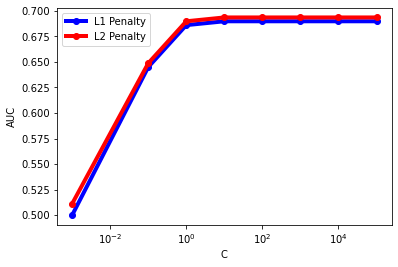

In [363]:
val_aucs_l1 = [val_aucs[i] for i in range(len(val_aucs)) if parameters[i]['penalty']=="l1"]
val_aucs_l2 = [val_aucs[i] for i in range(len(val_aucs)) if parameters[i]['penalty']=="l2"]
C_values = [parameters[i]['C'] for i in range(len(parameters)) if parameters[i]['penalty']=="l2"]

fig, ax = plt.subplots()
ax.semilogx( C_values, val_aucs_l1, marker='.', markerfacecolor='blue', markersize=12, color='blue', linewidth=4, label='L1 Penalty')
ax.semilogx( C_values, val_aucs_l2, marker='.', markerfacecolor='red', markersize=12, color='red', linewidth=4, label='L2 Penalty')
ax.set_xlabel("C")
ax.set_ylabel("AUC")
plt.legend()
plt.show()

**TODO: From the plot above, interpret why the hyperparameters were chosen as such.**


#### 4.7. Interpreting the predictive accuracy

Until now, we used the predictive accuracy of the logistic regression model, which refers to the concordance between an individual's credit risk and the label assigned to that individual by the model. For instance, how often did the model predict that a person was a "bad credit risk" and that person in fact defaulted on a loan? 

We can think of this in terms of a 2x2 table (also called a *confusion matrix*):

|      | Did not default | Defaulted   |
| :---        |    :----:   |          ---: |
| **Labeled bad credit risk**  | A       | B   |
| **Labeled good credit risk**   | C       | D      |

**TODO: What are the generic terms for A and D and what do they represent?**

In [396]:
y_val_list = y_val.tolist()
pred_list = pred.tolist()
print("Actual value (Default):", y_val_list.count(0))
print("Actual value (Does not Default): ", y_val_list.count(1))
print("Predict (Bad Credit)", pred_list.count(0))
print("Predict (Good Credit)", pred_list.count(1))

conf_matrix = confusion_matrix(y_val, pred, labels=[0, 1])
print(conf_matrix)

Actual value (Default): 67
Actual value (Does not Default):  133
Predict (Bad Credit) 49
Predict (Good Credit) 151
[[ 31  36]
 [ 18 115]]


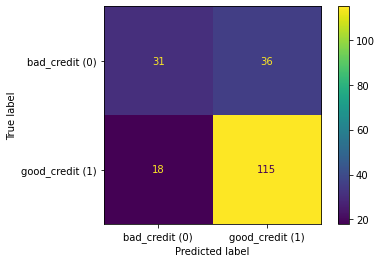

In [390]:
# cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["bad_credit (0)","good_credit (1)"])

disp.plot()
plt.show()

**TODO: Based on this confusion matrix, input the number of true positives, false positives, true negatives, and false negatives:**

In [ ]:
true_positive  = 0#@param {type:"number"}
false_positive = 0#@param {type:"number"}
true_negative  = 0#@param {type:"number"}
false_negative = 0#@param {type:"number"}

Calculate the false positive rate:

FPR = FP / (FP+TN)

In [ ]:
# write code to calculate the false positive rate for all applicants
# in this code cell

Calculate the false *negative* rate:

FNR = FN / (FN+TP)

In [ ]:
# write code to calculate the false negative rate for all applicants
# in this code cell

**TODO: Take a moment to review the false positive rate and false negative rate above. For this application, comment on whether one metric is more desired over another?**

#### 4.8. Now, let's try another popular machine learning model, a Random Forest Classifier. You only need to change step 4.4 above, evaluate the trained random forest and compute the statistics as in step 4.7. You may also use hyperparameter tuning and compare the best random forest classifier with the best logistic regression classifier.

**TODO: Compare your results (accuracy and AUC) for the two models and comment on the similarities and differences in their performances.**

# Submitting this Assignment Notebook

Once complete, please submit your assignment notebook as an attachment under "Assignments > Assignment 1" on Brightspace. You can download a copy of your notebook using ```File > Download .ipynb```. Please ensure you submit the `.ipynb` file (and not a `.py` file).